In [1]:
CPU_CORES = 51
addprocs(CPU_CORES - 1);
@everywhere using DistributedArrays, JuMP, Distributions, Ipopt
using StatsBase

 overwritten in module StatsBase at /home/cqgz21/.julia/v0.6/StatsBase/src/hist.jl:533.
midpoints(Base.Range{T} where T) in module Base at deprecated.jl:56 overwritten in module StatsBase at /home/cqgz21/.julia/v0.6/StatsBase/src/hist.jl:535.
 in module StatsBase at /home/cqgz21/.julia/v0.6/StatsBase/src/hist.jl:535.
midpoints(Base.Range{T} where T) in module Base at deprecated.jl:56 overwritten in module StatsBase at /home/cqgz21/.julia/v0.6/StatsBase/src/hist.jl:535.
 at deprecated.jl:56 overwritten in module StatsBase at /home/cqgz21/.julia/v0.6/StatsBase/src/hist.jl:533.


In [2]:
print(nprocs(),"\n")
print(nworkers(),"\n")
print(workers(),"\n")

51
50
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [3]:
@everywhere landscape1= [0. 0 0 2 2 0 0 0 2 0 0 2;
              2 0 1 2 5 5 0 0 2 0 0 0;
              3 1 2 2 1 1 2 0 0 3 0 0;
              2 1 1 2 1 2 2 0 3 4 4 0
              2 2 1 1 1 1 1 0 3 4 4 3;
              2 2 1 1 1 1 1 1 3 3 3 0;
              0 2 0 1 5 5 5 0 1 1 0 3;
              3 0 0 1 0 0 2 0 0 3 1 3;
              3 4 0 1 1 3 2 2 2 3 3 3;
              4 3 2 0 0 3 2 2 2 3 2 2] + 1
@everywhere Ncell = 30

In [4]:
@everywhere function create_pixel_mat(landscape, ordered_vec)
    retmat = deepcopy(landscape)
    for i = 1:length(ordered_vec)
        retmat[abs.(retmat - i) .< 0.000000001] = ordered_vec[i]
    end
    
    if size(retmat) == (10,12)
        retmat_zone = hcat(reshape(retmat[1:5 , 1:6],Ncell),
            reshape(retmat[1:5 , 7:12],Ncell),
            reshape(retmat[6:10 , 1:6],Ncell),
            reshape(retmat[6:10 , 7:12],Ncell))
    end
    retmat_zone
end


In [5]:
# Using the prior and visibility info given in the DCA paper
# These have @everywhere because they are fixed. Better declare them in each process rather than
# copying from the parent process
@everywhere s1 = create_pixel_mat(landscape1, [0.4,0.9,0.3,0.2,0.1,0.8])
@everywhere s2 = create_pixel_mat(landscape1, [0.5,0.1,0.1,0.7,0.6,0.9])
@everywhere s3 = create_pixel_mat(landscape1, [0.6,0.1,0.4,0.8,0.7,0.1])
@everywhere s4 = create_pixel_mat(landscape1, [0.8,0.1,0.6,0.2,0.1,0.7])
@everywhere s5 = create_pixel_mat(landscape1, [0.5,0.3,0.5,0.4,0.3,0.6])
@everywhere s6 = create_pixel_mat(landscape1, [0.1,0.5,0.2,0.6,0.5,0.2])




@everywhere Z = 4 # number of zones
@everywhere S = 6 # number of sensors
@everywhere W = reshape(hcat(s1,s2,s3,s4,s5,s6),Ncell,Z,S) # visibility tensor



@everywhere θ = 0.3
@everywhere N = 50
@everywhere Threshold = convert(Int64,floor(N * θ)) # for accepting P computed from each sample
@everywhere epsilon = 1e-5


# No @everywhere because these are only used by the parent process
maxiter = 15 # number of iterations for 



# No @everywhere because these are changing, pass into functions as parameters

Φ = 5
prior_ordered_vec = [0.0085,0.001,0.0115,0.013,0.014,0] # prior of target, order given in the paper
prior = create_pixel_mat(landscape1, prior_ordered_vec)
print(sum(prior))





1.0000000000000004

In [114]:
s1

30×4 Array{Float64,2}:
 0.600463  0.600463  0.171074  0.671982
 0.171074  0.600463  0.600463  0.721264
 0.18214   0.171074  0.18214   0.171074
 0.171074  0.171074  0.18214   0.171074
 0.171074  0.671982  0.15142   0.171074
 0.600463  0.600463  0.171074  0.671982
 0.600463  0.600463  0.171074  0.600463
 0.671982  0.600463  0.600463  0.600463
 0.671982  0.600463  0.15142   0.171074
 0.171074  0.600463  0.18214   0.171074
 0.600463  0.171074  0.671982  0.18214 
 0.671982  0.171074  0.600463  0.671982
 0.171074  0.600463  0.600463  0.600463
 ⋮                                     
 0.171074  0.15142   0.671982  0.18214 
 0.671982  0.15142   0.600463  0.18214 
 0.171074  0.600463  0.671982  0.18214 
 0.721264  0.600463  0.721264  0.600463
 0.671982  0.600463  0.600463  0.671982
 0.671982  0.15142   0.671982  0.18214 
 0.671982  0.15142   0.600463  0.171074
 0.600463  0.171074  0.671982  0.600463
 0.721264  0.600463  0.721264  0.18214 
 0.671982  0.600463  0.600463  0.18214 
 0.171074  0.6004

In [6]:



####################################
## CE Algorithm parallel N

@everywhere function solve_alloc(u, Φ,prior)

    m_ϕ = Model(solver = IpoptSolver(print_level=0))

    @variable(m_ϕ,ϕvar[1:Ncell,1:Z,1:S]) # resource allocation for each senor in each zone in each cell
    @variable(m_ϕ,exponential[1:Ncell,1:Z])
    @variable(m_ϕ, aux[1:Ncell,1:Z])
    @objective(m_ϕ, Min, sum(prior .* exponential))
    @NLconstraint(m_ϕ, [i=1:Ncell,j=1:Z], exp(aux[i,j]) <= exponential[i,j])
    @constraint(m_ϕ,aux .== squeeze(-sum(W .* ϕvar .* reshape(u,1,Z,S),3),3))
    @constraint(m_ϕ, exponential .>= 0)
    @constraint(m_ϕ,ϕvar .>= 0)
    @constraint(m_ϕ,[i=1:Z,j=1:S],sum(ϕvar[:,i,j]) <= Φ)

    solve(m_ϕ)
    getobjectivevalue(m_ϕ), transpose(u)
end
    
    

function CE_parallel(Φ,prior)
    
    P = ones(S,Z)/Z
    for iter=1:maxiter

        cumsumP = cumsum(P,2)
        
        vec_tile = rand(Uniform(0,1), S * N,1)
        cumsumP_tile = repmat(cumsumP,N)
        which_zone = floor.(findmax(cumsumP_tile .> vec_tile,2)[2] / (S*N) - epsilon) + 1
        u = abs.(repmat(transpose(1:Z),S*N,1) .- which_zone) .< epsilon
        u = transpose(u)
        
        arr_obj = []
        arr_assign = zeros(S,Z,N)
#         tic()
        retobj = @DArray [solve_alloc(u[:,(i-1)*S+1:i*S],Φ,prior) for i = 1:N]
#         toc()
        for i = 1:N
            push!(arr_obj, retobj[i][1])
            arr_assign[:,:,i] = retobj[i][2]
        end
 
        best_ind = sortperm(arr_obj)[1:Threshold]
        P = squeeze(sum(arr_assign[:,:,best_ind],3)/Threshold,3)
    end
    
    u = transpose(P)
    m_ϕ = Model(solver = IpoptSolver(print_level=0))

    @variable(m_ϕ,ϕvar[1:Ncell,1:Z,1:S])
    @variable(m_ϕ,exponential[1:Ncell,1:Z])
    @variable(m_ϕ, aux[1:Ncell,1:Z])
    @objective(m_ϕ, Min, sum(prior .* exponential))
    @NLconstraint(m_ϕ, [i=1:Ncell,j=1:Z], exp(aux[i,j]) <= exponential[i,j])
    @constraint(m_ϕ,aux .== squeeze(-sum(W .* ϕvar .* reshape(u,1,Z,S),3),3))
    @constraint(m_ϕ, exponential .>= 0)
    @constraint(m_ϕ,ϕvar .>= 0)
    @constraint(m_ϕ,[i=1:Z,j=1:S],sum(ϕvar[:,i,j]) <= Φ)

    solve(m_ϕ)
    
    getobjectivevalue(m_ϕ), P, exp.(getvalue(aux)), getvalue(ϕvar)
    
    
    
end


CE_parallel (generic function with 1 method)

In [7]:
tic()
Φ = 5
obj, assignment, prob_nondetect, res_alloc = CE_parallel(Φ,prior)
toc()
print(obj)


	From worker 14:	
	From worker 14:	******************************************************************************
	From worker 14:	This program contains Ipopt, a library for large-scale nonlinear optimization.
	From worker 14:	 Ipopt is released as open source code under the Eclipse Public License (EPL).
	From worker 14:	         For more information visit http://projects.coin-or.org/Ipopt
	From worker 14:	******************************************************************************
	From worker 14:	
	From worker 7:	
	From worker 7:	******************************************************************************
	From worker 7:	This program contains Ipopt, a library for large-scale nonlinear optimization.
	From worker 7:	 Ipopt is released as open source code under the Eclipse Public License (EPL).
	From worker 7:	         For more information visit http://projects.coin-or.org/Ipopt
	From worker 7:	******************************************************************************
	From work

	From worker 12:	
	From worker 12:	******************************************************************************
	From worker 12:	This program contains Ipopt, a library for large-scale nonlinear optimization.
	From worker 12:	 Ipopt is released as open source code under the Eclipse Public License (EPL).
	From worker 12:	         For more information visit http://projects.coin-or.org/Ipopt
	From worker 12:	******************************************************************************
	From worker 12:	
	From worker 4:	
	From worker 4:	******************************************************************************
	From worker 4:	This program contains Ipopt, a library for large-scale nonlinear optimization.
	From worker 4:	 Ipopt is released as open source code under the Eclipse Public License (EPL).
	From worker 4:	         For more information visit http://projects.coin-or.org/Ipopt
	From worker 4:	******************************************************************************
	From work

	From worker 20:	
	From worker 20:	******************************************************************************
	From worker 20:	This program contains Ipopt, a library for large-scale nonlinear optimization.
	From worker 20:	 Ipopt is released as open source code under the Eclipse Public License (EPL).
	From worker 20:	         For more information visit http://projects.coin-or.org/Ipopt
	From worker 20:	******************************************************************************
	From worker 20:	
	From worker 13:	
	From worker 13:	******************************************************************************
	From worker 13:	This program contains Ipopt, a library for large-scale nonlinear optimization.
	From worker 13:	 Ipopt is released as open source code under the Eclipse Public License (EPL).
	From worker 13:	         For more information visit http://projects.coin-or.org/Ipopt
	From worker 13:	******************************************************************************
	Fro

In [52]:
#######################################
# Perturb prior
#######################################
# function prior_perturb(mag)
#     new_prior = zeros(120)
#     counter = 0
#     for i = 1:length(new_prior)
#         val = reshape(prior,120)[i]
#         if val > 0
#             perturb = rand(Normal(0,val)) * mag
#             newval = val + perturb
#             if newval < 0
#                 counter = counter + 1
#             end
#             newval = abs(newval)
#         else
#             newval = val
#         end
#         new_prior[i] = newval
#     end
#     new_prior = reshape(new_prior/sum(new_prior),30,4)
#     return new_prior, counter
# end


function prior_perturb(mag)
    new_prior = zeros(120)
    counter = 0
    for i = 1:length(new_prior)
        val = reshape(prior,120)[i]
        if val > 0
            perturb = rand(Normal(0,val)) * mag
            newval = val + perturb
            if newval < 0
                counter = counter + 1
            end
            newval = abs(newval)
        else
            newval = val
        end
        new_prior[i] = newval
    end
    new_prior = reshape(new_prior/sum(new_prior),30,4)
    return new_prior, counter
end

prior_perturb (generic function with 1 method)

In [51]:
prior_perturb(0.1)

LoadError: [91mArgumentError: Normal: the condition σ > zero(σ) is not satisfied.[39m

In [9]:
# small perturbations

num_trials = 1000
nondetection_prior_perturb = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_prior,counter = prior_perturb(0.1)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_prior - prior))
    nondetection_prior_perturb[i] = sum(new_prior .* exp.( squeeze(-sum(W .* res_alloc .* reshape(transpose(assignment),1,Z,S),3),3)))
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_prior_perturb)

0.07936301241101855
0.0


Summary Stats:
Mean:           0.817921
Minimum:        0.814095
1st Quartile:   0.817054
Median:         0.817846
3rd Quartile:   0.818851
Maximum:        0.821886


In [10]:
# medium perturbations

num_trials = 1000
nondetection_prior_perturb = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_prior,counter = prior_perturb(0.5)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_prior - prior))
    nondetection_prior_perturb[i] = sum(new_prior .* exp.( squeeze(-sum(W .* res_alloc .* reshape(transpose(assignment),1,Z,S),3),3)))
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_prior_perturb)

0.38560209857654093
2.572


Summary Stats:
Mean:           0.818031
Minimum:        0.798014
1st Quartile:   0.813847
Median:         0.817889
3rd Quartile:   0.822169
Maximum:        0.835953


In [11]:
# large perturbations

num_trials = 1000
nondetection_prior_perturb = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_prior,counter = prior_perturb(1)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_prior - prior))
    nondetection_prior_perturb[i] = sum(new_prior .* exp.( squeeze(-sum(W .* res_alloc .* reshape(transpose(assignment),1,Z,S),3),3)))
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_prior_perturb)

0.558347387093657
18.292


Summary Stats:
Mean:           0.818026
Minimum:        0.786988
1st Quartile:   0.811594
Median:         0.818337
3rd Quartile:   0.824448
Maximum:        0.849007


In [12]:
#######################################
# Perturb sensor visibility
#######################################


# data frpm Thi's paper. table 1
sen_visibility_tbl = [0.4 0.5 0.6 0.8 0.5 0.1;
    0.9 0.1 0.1 0.1 0.3 0.5;
    0.3 0.1 0.4 0.6 0.5 0.2;
    0.2 0.7 0.8 0.2 0.4 0.6;
    0.1 0.6 0.7 0.1 0.3 0.5;
    0.8 0.9 0.1 0.7 0.6 0.2]

function visibility_perturb(mag)
    counter_neg = 0
    counter_1plus = 0
    @everywhere new_visibility_tbl = zeros(6,6)
    for i=1:6
        for j=1:6
            val = sen_visibility_tbl[i,j]
            if val > 0
                perturb = rand(Normal(0,val)) * mag
                newval = val + perturb
                if newval < 0
                    counter_neg = counter_neg + 1
                    newval = abs(newval)
                elseif newval > 1
                    counter_1plus = counter_1plus + 1
                    newval = 1
                end
                
            else
                newval = val
            end
            new_visibility_tbl[i,j] = newval
        end
    end
    
    @everywhere s1 = create_pixel_mat(landscape1, new_visibility_tbl[:,1])
    @everywhere s2 = create_pixel_mat(landscape1, new_visibility_tbl[:,2])
    @everywhere s3 = create_pixel_mat(landscape1, new_visibility_tbl[:,3])
    @everywhere s4 = create_pixel_mat(landscape1, new_visibility_tbl[:,4])
    @everywhere s5 = create_pixel_mat(landscape1, new_visibility_tbl[:,5])
    @everywhere s6 = create_pixel_mat(landscape1, new_visibility_tbl[:,6])
    @everywhere new_W = reshape(hcat(s1,s2,s3,s4,s5,s6),Ncell,Z,S) # visibility tensor

    
    return new_W, counter_neg, counter_1plus
end




visibility_perturb (generic function with 1 method)

In [13]:
# small perturbations

num_trials = 1000
nondetection_W_perturb = zeros(num_trials)
diff_record = 0
counter_neg_record = 0
counter_1plus_record = 0
for i=1:num_trials
    new_W, counter_neg, counter_1plus = visibility_perturb(0.1)
    counter_neg_record = counter_neg_record + counter_neg
    counter_1plus_record = counter_1plus_record + counter_1plus
    diff_record = diff_record + sum(abs.(new_W - W))
    nondetection_W_perturb[i] = sum(prior .* exp.( squeeze(-sum(new_W .* res_alloc .* reshape(transpose(assignment),1,Z,S),3),3)))
end
print(diff_record/num_trials,"\n")
print(counter_neg_record/num_trials,"\n")
print(counter_1plus_record/num_trials,"\n")
summarystats(nondetection_W_perturb)

23.897752561175523
0.0
0.294


Summary Stats:
Mean:           0.818388
Minimum:        0.800480
1st Quartile:   0.814733
Median:         0.818430
3rd Quartile:   0.821952
Maximum:        0.835747


In [14]:
# Medium perturbations

num_trials = 1000
nondetection_W_perturb = zeros(num_trials)
diff_record = 0
counter_neg_record = 0
counter_1plus_record = 0
for i=1:num_trials
    new_W, counter_neg, counter_1plus = visibility_perturb(0.5)
    counter_neg_record = counter_neg_record + counter_neg
    counter_1plus_record = counter_1plus_record + counter_1plus
    diff_record = diff_record + sum(abs.(new_W - W))
    nondetection_W_perturb[i] = sum(prior .* exp.( squeeze(-sum(new_W .* res_alloc .* reshape(transpose(assignment),1,Z,S),3),3)))
end
print(diff_record/num_trials,"\n")
print(counter_neg_record/num_trials,"\n")
print(counter_1plus_record/num_trials,"\n")
summarystats(nondetection_W_perturb)

106.5297721554706
0.882
2.872


Summary Stats:
Mean:           0.826996
Minimum:        0.764574
1st Quartile:   0.810153
Median:         0.826119
3rd Quartile:   0.842677
Maximum:        0.909858


In [15]:
# Large perturbations

num_trials = 1000
nondetection_W_perturb = zeros(num_trials)
diff_record = 0
counter_neg_record = 0
counter_1plus_record = 0
for i=1:num_trials
    new_W, counter_neg, counter_1plus = visibility_perturb(1)
    counter_neg_record = counter_neg_record + counter_neg
    counter_1plus_record = counter_1plus_record + counter_1plus
    diff_record = diff_record + sum(abs.(new_W - W))
    nondetection_W_perturb[i] = sum(prior .* exp.( squeeze(-sum(new_W .* res_alloc .* reshape(transpose(assignment),1,Z,S),3),3)))
end
print(diff_record/num_trials,"\n")
print(counter_neg_record/num_trials,"\n")
print(counter_1plus_record/num_trials,"\n")
summarystats(nondetection_W_perturb)

151.95539162699686
5.839
5.367


Summary Stats:
Mean:           0.825411
Minimum:        0.737670
1st Quartile:   0.803081
Median:         0.823534
3rd Quartile:   0.846301
Maximum:        0.930564


In [ ]:
####################################################
## Varying the total resource each sensor has. Not relevant to the discussion of this notebook
#####################################################

Φ_vec = 5:5:40
Φ_vec_len = length(Φ_vec)
obj_vec = zeros(Φ_vec_len,1)

tic()
################## Takes a while to run (~3 mins) ########################
for i=1:Φ_vec_len
    Φ = Φ_vec[i]
    obj, assignment, prob_nondetect, res_alloc = CE_parallel(Φ,prior)
    obj_vec[i] = obj
    print("Φ: ", Φ, " done.\n")
end
toc()

display(obj_vec)


Amount of resource    Paper        Mine
5                     0.818577     0.816912
10                    0.684701     0.683561
15                    0.580673     0.575656
20                    0.500550     0.495109
25                    0.428900     0.433506
30                    0.372219     0.359684
35                    0.327574     0.303628
40                    0.292742     0.283595

In [ ]:
##############################################
## Moving Target
##############################################

In [16]:
moving_mat= [0.0 0.0 0.0;
             0.0 0.3 0.1;
             0.0 0.1 0.5]
sum(moving_mat)

1.0

In [17]:
# construct a 30x4x30x4 one step moving probability tensor
# first, construct 120x120 one step transition matrix

function construct_c2c(moving_mat)
    # here we number all cells from 1 to 120 in a row-major fashion
    c2c = zeros(Ncell * Z, Ncell * Z)
    for i = 1:(Ncell * Z)
        # Stay in current cell
        c2c[i,i] = moving_mat[2,2]

        # move right
        if mod(i,12) ==  0 # right end 
            c2c[i,i] = c2c[i,i] + moving_mat[2,3]
        else
            c2c[i,i+1] = moving_mat[2,3]
        end

        # move down
        if i > 12 * (10-1) # bottom end
            c2c[i,i] = c2c[i,i] + moving_mat[3,2]
        else
            c2c[i,i+12] = moving_mat[3,2]
        end

        # move diagonal
        if (mod(i,12) == 0) | (i > 12 * (10-1))
            c2c[i,i] = c2c[i,i] + moving_mat[3,3]
        else
            c2c[i,i+12+1] = moving_mat[3,3]
        end


    end

    # convert the 120x120 matrix into 30x4x30x4 tensor
    # Note that Julia is column major: suppose the first (leftmost, upmost) cell
    # is cell 1, cell 2 refers to the cell below cell 1 not the cell to the right
    # This affects how cell index is assigned
    c2c_tensor = zeros(Ncell,Z,Ncell,Z)
    for i=1:Ncell*Z
        zone_prev = (i / 60 > 1) * 2 + ((mod(i,12) / 6 > 1) | (mod(i,12) == 0)) + 1
        offset_prev = [0,6,60,66][zone_prev]
        cell_prev = (rem(i-offset_prev,12) - 1) * 5 + div(i-offset_prev,12) + 1 # column major in julia
        for j=1:Ncell*Z
            zone_cur = (j / 60 > 1) * 2 + ((mod(j,12) / 6 > 1) | (mod(j,12) == 0)) + 1
            offset_cur = [0,6,60,66][zone_cur]
            cell_cur = (rem(j-offset_cur,12) - 1) * 5 + div(j-offset_cur,12) + 1 # column major in julia
            c2c_tensor[cell_prev,zone_prev,cell_cur,zone_cur] = c2c[i,j]
        end
    end
    
    return c2c_tensor
end

construct_c2c (generic function with 1 method)

In [18]:
c2c_tensor = construct_c2c(moving_mat)

30×4×30×4 Array{Float64,4}:
[:, :, 1, 1] =
 0.3  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 ⋮                 
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.1  0.0  0.0  0.0
 0.3  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 ⋮                 
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 

In [19]:
# Myopic and Optimal Search Plan (without cross-cueing)

In [20]:
T = 4
Φ = 5
Total_Iter = 4 # the number of iterations to go from myopic search plan to optimal search plan

4

In [21]:
################## Takes a while to run ########################

function mov_target_CE()
    DTensor = ones(Ncell,Z,T)
    moving_target_obj_vec = zeros(Total_Iter,T)
    prob_nondetect_Tensor = zeros(Ncell,Z,T)
    final_assignment = zeros(S,Z,T)
    final_res_alloc = zeros(Ncell,Z,S,T)
    
    
    for i = 1:Total_Iter
        # Initialize UTensor
        UTensor = zeros(Ncell,Z,T)
        UTensor[:,:,1] =  prior


        for τ = 1:4
            if τ > 1
                UTensor[:,:,τ] = sum(sum(c2c_tensor .* 
                        reshape(prob_nondetect_Tensor[:,:,τ-1],Ncell,Z,1,1) .* 
                        reshape(UTensor[:,:,τ-1],Ncell,Z,1,1),1),2)
            end
            β = UTensor[:,:,τ] .* DTensor[:,:,τ]
            obj, assignment, prob_nondetect, res_alloc = CE_parallel(Φ,β)
            final_assignment[:,:,τ] = assignment
            final_res_alloc[:,:,:,τ] = res_alloc
            prob_nondetect_Tensor[:,:,τ] = prob_nondetect
            moving_target_obj_vec[i,τ] = obj
            print("Iter: ",i,". Completed timestep: ",τ,". Obj: ",obj,"\n")
        end

        # Compute the DTensors using the nondetection probabilities at each timestep as calculated
        # in the previous iteration
        for τ = T-1:-1:1
            DTensor[:,:,τ] = sum(sum(c2c_tensor .* 
                    reshape(prob_nondetect_Tensor[:,:,τ+1],1,1,Ncell,Z) .* 
                    reshape(DTensor[:,:,τ+1],1,1,Ncell,Z),3),4)
        end
    end
    
    return moving_target_obj_vec, prob_nondetect_Tensor, final_assignment, final_res_alloc

end

mov_target_CE (generic function with 1 method)

In [22]:
tic()
moving_target_obj_vec, prob_nondetect_Tensor, final_assignment, final_res_alloc = mov_target_CE()
toc()


Iter: 1. Completed timestep: 1. Obj: 0.8179041164873561
Iter: 1. Completed timestep: 2. Obj: 0.6505678101747413
Iter: 1. Completed timestep: 3. Obj: 0.5046151719629298
Iter: 1. Completed timestep: 4. Obj: 0.38866534384414075
Iter: 2. Completed timestep: 1. Obj: 0.366048380654197
Iter: 2. Completed timestep: 2. Obj: 0.3607586947488234
Iter: 2. Completed timestep: 3. Obj: 0.35942879259754307
Iter: 2. Completed timestep: 4. Obj: 0.3602717991318498
Iter: 3. Completed timestep: 1. Obj: 0.35898958427567373
Iter: 3. Completed timestep: 2. Obj: 0.35542605772294183
Iter: 3. Completed timestep: 3. Obj: 0.3548340593849072
Iter: 3. Completed timestep: 4. Obj: 0.3552347257142886
Iter: 4. Completed timestep: 1. Obj: 0.35415977458286807
Iter: 4. Completed timestep: 2. Obj: 0.35356359496183065
Iter: 4. Completed timestep: 3. Obj: 0.35292393014248347
Iter: 4. Completed timestep: 4. Obj: 0.3541592305578466
elapsed time: 235.242531179 seconds


235.242531179

In [23]:
function compute_non_detection(prior, W, c2c_tensor)
    # Compute nondetection probability at each time step (used in computing U and D)
    nondetection_prob_holder = zeros(Ncell,Z,T)
    for i=1:T
        res_alloc_cur = final_res_alloc[:,:,:,i]
        assign_cur = final_assignment[:,:,i]
        nondetection_prob_holder[:,:,i] = exp.( squeeze(-sum(W .* res_alloc_cur .* reshape(transpose(assign_cur),1,Z,S),3),3))
    end


    # Compute U and D

    UTensor_holder = zeros(Ncell,Z,T)
    UTensor_holder[:,:,1] =  prior
    for i=2:T

        UTensor_holder[:,:,i] = sum(sum(c2c_tensor .* 
            reshape(nondetection_prob_holder[:,:,i-1],Ncell,Z,1,1) .* 
            reshape(UTensor_holder[:,:,i-1],Ncell,Z,1,1),1),2)

    end

    DTensor_holder = ones(Ncell,Z,T)
    for i = T-1:-1:1
        DTensor_holder[:,:,i] = sum(sum(c2c_tensor .* 
                reshape(nondetection_prob_holder[:,:,i+1],1,1,Ncell,Z) .* 
                reshape(DTensor_holder[:,:,i+1],1,1,Ncell,Z),3),4)
    end
    
    β_holder = UTensor_holder .* DTensor_holder
    time_step = T
    return sum(β_holder[:,:,time_step] .* nondetection_prob_holder[:,:,time_step])
end 
     
    


compute_non_detection (generic function with 1 method)

In [24]:
## non detection probaility without perturbation
compute_non_detection(prior, W, c2c_tensor)

0.3541589349338245

In [25]:
#######################################
# Perturb prior
#######################################


In [71]:
# small perturbations

num_trials = 1000
nondetection_prior_perturb_small = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_prior,counter = prior_perturb(0.1)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_prior - prior))
    nondetection_prior_perturb_small[i] = compute_non_detection(new_prior, W, c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_prior_perturb_small)

0.07949706055824232
0.0


Summary Stats:
Mean:           0.354161
Minimum:        0.349506
1st Quartile:   0.353029
Median:         0.354197
3rd Quartile:   0.355217
Maximum:        0.360249


In [72]:
# Med perturbations

num_trials = 1000
nondetection_prior_perturb_med = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_prior,counter = prior_perturb(0.3)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_prior - prior))
    nondetection_prior_perturb_med[i] = compute_non_detection(new_prior, W, c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_prior_perturb_med)

0.23831304826859673
0.039


Summary Stats:
Mean:           0.354113
Minimum:        0.339383
1st Quartile:   0.350805
Median:         0.354263
3rd Quartile:   0.357227
Maximum:        0.369177


In [85]:
# Large perturbations

num_trials = 1000
nondetection_prior_perturb_high = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_prior,counter = prior_perturb(0.5)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_prior - prior))
    nondetection_prior_perturb_high[i] = compute_non_detection(new_prior, W, c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_prior_perturb_high)

0.3861915924343384
2.609


Summary Stats:
Mean:           0.354088
Minimum:        0.334642
1st Quartile:   0.348874
Median:         0.353798
3rd Quartile:   0.358950
Maximum:        0.375440


In [29]:
#######################################
# Perturb sensor visibility
#######################################

In [43]:
# small perturbations

num_trials = 1000
nondetection_W_perturb_small = zeros(num_trials)
diff_record = 0
counter_neg_record = 0
counter_1plus_record = 0
for i=1:num_trials
    new_W, counter_neg, counter_1plus = visibility_perturb(0.1)
    counter_neg_record = counter_neg_record + counter_neg
    counter_1plus_record = counter_1plus_record + counter_1plus
    diff_record = diff_record + sum(abs.(new_W - W))
    nondetection_W_perturb_small[i] = compute_non_detection(prior, new_W, c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_neg_record/num_trials,"\n")
print(counter_1plus_record/num_trials,"\n")
summarystats(nondetection_W_perturb_small)

23.91602283636644
0.0
0.295


Summary Stats:
Mean:           0.355758
Minimum:        0.328698
1st Quartile:   0.349133
Median:         0.355603
3rd Quartile:   0.362408
Maximum:        0.387792


In [44]:
# Med perturbations

num_trials = 1000
nondetection_W_perturb_med = zeros(num_trials)
diff_record = 0
counter_neg_record = 0
counter_1plus_record = 0
for i=1:num_trials
    new_W, counter_neg, counter_1plus = visibility_perturb(0.3)
    counter_neg_record = counter_neg_record + counter_neg
    counter_1plus_record = counter_1plus_record + counter_1plus
    diff_record = diff_record + sum(abs.(new_W - W))
    nondetection_W_perturb_med[i] = compute_non_detection(prior, new_W, c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_neg_record/num_trials,"\n")
print(counter_1plus_record/num_trials,"\n")
summarystats(nondetection_W_perturb_med)

67.95569356486294
0.013
1.504


Summary Stats:
Mean:           0.368738
Minimum:        0.297331
1st Quartile:   0.349521
Median:         0.367017
3rd Quartile:   0.386167
Maximum:        0.484635


In [45]:
# Large perturbations

num_trials = 1000
nondetection_W_perturb_high = zeros(num_trials)
diff_record = 0
counter_neg_record = 0
counter_1plus_record = 0
for i=1:num_trials
    new_W, counter_neg, counter_1plus = visibility_perturb(0.5)
    counter_neg_record = counter_neg_record + counter_neg
    counter_1plus_record = counter_1plus_record + counter_1plus
    diff_record = diff_record + sum(abs.(new_W - W))
    nondetection_W_perturb_high[i] = compute_non_detection(prior, new_W, c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_neg_record/num_trials,"\n")
print(counter_1plus_record/num_trials,"\n")
summarystats(nondetection_W_perturb_high)

106.849070415876
0.828
2.918


Summary Stats:
Mean:           0.388853
Minimum:        0.268204
1st Quartile:   0.354164
Median:         0.383257
3rd Quartile:   0.419296
Maximum:        0.581428


In [33]:
#######################################
# Perturb movement distribution
#######################################

In [34]:
function move_perturb(mag)
    new_move = zeros(9)
    counter = 0
    for i = 1:length(new_move)
        val = reshape(moving_mat,9)[i]
        if val > 0
            perturb = rand(Normal(0,val)) * mag
            newval = val + perturb
            if newval < 0
                counter = counter + 1
            end
            newval = abs(newval)
        else
            newval = val # val == 0 case, do not apply perturbation
        end
        new_move[i] = newval
    end
    new_move = reshape(new_move/sum(new_move),3,3)
    return new_move, counter
end

move_perturb (generic function with 1 method)

In [80]:
# small perturbations

num_trials = 1000
nondetection_move_perturb_small = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_move, counter = move_perturb(0.1)
    new_c2c_tensor = construct_c2c(new_move)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_move - moving_mat))
    nondetection_move_perturb_small[i] = compute_non_detection(prior, W, new_c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_move_perturb_small)

0.06188385887258301
0.0


Summary Stats:
Mean:           0.354211
Minimum:        0.330078
1st Quartile:   0.348811
Median:         0.353717
3rd Quartile:   0.358653
Maximum:        0.379313


In [81]:
# Med perturbations

num_trials = 1000
nondetection_move_perturb_med = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_move, counter = move_perturb(0.3)
    new_c2c_tensor = construct_c2c(new_move)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_move - moving_mat))
    nondetection_move_perturb_med[i] = compute_non_detection(prior, W, new_c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_move_perturb_med)

0.19144889011139488
0.003


Summary Stats:
Mean:           0.355094
Minimum:        0.294574
1st Quartile:   0.339341
Median:         0.353191
3rd Quartile:   0.369006
Maximum:        0.456355


In [77]:
# Large perturbations

num_trials = 1000
nondetection_move_perturb_high = zeros(num_trials)
diff_record = 0
counter_record = 0
for i=1:num_trials
    new_move, counter = move_perturb(0.5)
    new_c2c_tensor = construct_c2c(new_move)
    counter_record = counter_record + counter
    diff_record = diff_record + sum(abs.(new_move - moving_mat))
    nondetection_move_perturb_high[i] = compute_non_detection(prior, W, new_c2c_tensor)
end
print(diff_record/num_trials,"\n")
print(counter_record/num_trials,"\n")
summarystats(nondetection_move_perturb_high)

0.32664863978334435
0.099


Summary Stats:
Mean:           0.360573
Minimum:        0.264263
1st Quartile:   0.331717
Median:         0.355370
3rd Quartile:   0.382007
Maximum:        0.500746


In [78]:
nondetection_move_perturb_high

1000-element Array{Float64,1}:
 0.307959
 0.344137
 0.420954
 0.32982 
 0.278781
 0.384367
 0.382619
 0.406527
 0.357561
 0.341211
 0.301123
 0.275195
 0.378649
 ⋮       
 0.308691
 0.375457
 0.387646
 0.398694
 0.330792
 0.282972
 0.287504
 0.398228
 0.33081 
 0.34768 
 0.337156
 0.295382

In [ ]:
####################################################
## Comparing my own implementation results vs the paper. Not relevant to the discussion of this notebook
#####################################################

# rows denote each iteration of going to myopic search plan to
# optimal search plan
# column denote each time step within the iteration
moving_target_obj_vec


Time    Myopic                  Optimal
        Paper       Mine        Paper       Mine
1       0.8198461   0.817348    0.2962617   0.352191
2       0.6379034   0.652625    0.2958389   0.351842
3       0.4727772   0.506620    0.2954212   0.351133
4       0.3325033   0.392449    0.2950101   0.350590

In [63]:
using PyPlot
ioff()

No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlibWARNING: 
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlibWARNING: 
No working GUI backend found for matplotlib
No working GUI backend found for matplotlibWARNING: 
No working GUI backend found for matplotlib
No working GUI backend found for matplotlibNo working GUI backend found for matplotlib


No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib
No working GUI backend found for matplotlib


No working GUI backend found for matplotlib
No

In [64]:
num = 5
data = Array{Any}(num) # Preallocate an ANY array for the storage of final values
for i=1:1:num
    num1 = round.(40rand(1)) + 10
    num1 = Int(num1[1])
    num2 = round.(20rand(1)) + 10
    num2 = Int(num2[1])
    num3 = round.(10rand(1)) + 1
    num3 = Int(num3[1])
    num4 = round.(10rand(1)) + 1
    num4 = Int(num4[1])

    spread = 100rand(num1)
    center = 50rand(num2)
    flier_high = 100rand(num3) + 100
    flier_low = -100rand(num4)
    data[i] = [spread,center,flier_high,flier_low;];
end

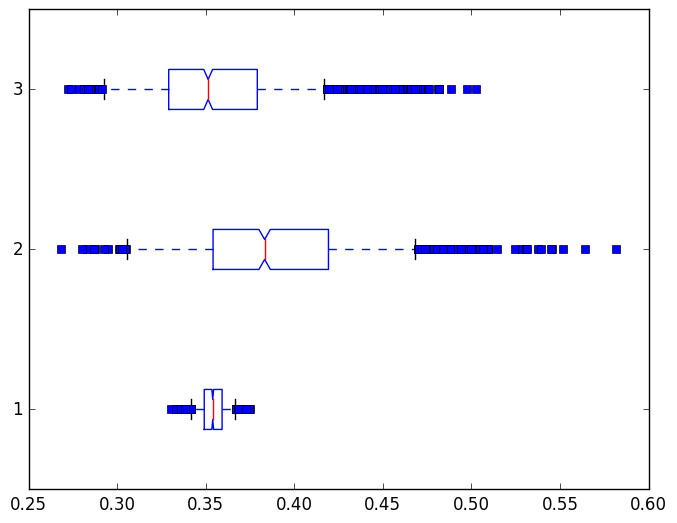

Dict{Any,Any} with 6 entries:
  "medians"  => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "whiskers" => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "fliers"   => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "boxes"    => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "caps"     => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "means"    => Any[]

In [70]:
boxplot(data2, # Each column/cell is one box
notch=true, # Notched center
whis=0.75, # Whisker length as a percent of inner quartile range
widths=0.25, # Width of boxes
vert=false, # Horizontal boxes
sym="rs") # Symbol color and shape (rs = red square)

In [67]:
data

5-element Array{Any,1}:
 [36.0482, 33.843, 50.4803, 59.5255, 5.12624, 13.3224, 66.6734, 12.2616, 47.2672, 52.115  …  7.48053, 22.3924, 169.395, 190.916, 161.25, 171.065, 118.402, -70.8405, -81.3411, -91.1574]        
 [98.6265, 62.0043, 87.2115, 18.5212, 26.2569, 46.8207, 63.526, 33.5228, 44.3332, 24.1927  …  127.212, 159.425, 120.371, 102.23, 130.257, 172.39, 139.311, -53.2146, -3.07606, -28.8224]        
 [4.67311, 55.3364, 22.2014, 37.4088, 11.7031, 40.768, 95.0556, 53.8922, 92.4777, 32.023  …  -57.2973, -70.9384, -86.3653, -71.2527, -53.6549, -53.3263, -42.1107, -14.0524, -78.0451, -6.02723]
 [76.9741, 81.632, 81.7309, 12.2904, 78.2243, 1.24946, 8.55363, 40.2757, 29.684, 32.7666  …  130.721, 159.415, 132.371, 162.142, -66.6618, -37.8696, -4.88835, -96.6365, -89.1058, -27.1564]    
 [31.2258, 49.1542, 51.8494, 42.3751, 72.2791, 41.6997, 97.3576, 17.0061, 65.9011, 34.1933  …  22.5058, 32.3747, 11.6883, 28.1626, 105.817, 160.73, 148.725, -85.2175, -28.6547, -60.2025]      

In [90]:
data_small = [nondetection_prior_perturb_small nondetection_W_perturb_small nondetection_move_perturb_small]
data_med = [nondetection_prior_perturb_med nondetection_W_perturb_med nondetection_move_perturb_med]
data_high = [nondetection_prior_perturb_high nondetection_W_perturb_high nondetection_move_perturb_high]

1000×3 Array{Float64,2}:
 0.352066  0.391854  0.307959
 0.361913  0.381204  0.344137
 0.344019  0.368595  0.420954
 0.365513  0.343785  0.32982 
 0.359292  0.411562  0.278781
 0.353637  0.338183  0.384367
 0.348027  0.381484  0.382619
 0.359586  0.410962  0.406527
 0.380781  0.356899  0.357561
 0.3729    0.38138   0.341211
 0.34229   0.347037  0.301123
 0.351457  0.351399  0.275195
 0.353416  0.312716  0.378649
 ⋮                           
 0.340794  0.312212  0.308691
 0.349241  0.362237  0.375457
 0.365958  0.317388  0.387646
 0.343705  0.395809  0.398694
 0.345938  0.381926  0.330792
 0.342469  0.352     0.282972
 0.366018  0.401577  0.287504
 0.359775  0.414281  0.398228
 0.355151  0.448086  0.33081 
 0.34899   0.383543  0.34768 
 0.360937  0.318479  0.337156
 0.352051  0.356491  0.295382

In [113]:
writecsv("data_small.txt", data_small)
writecsv("data_med.txt", data_med)
writecsv("data_high.txt", data_high)

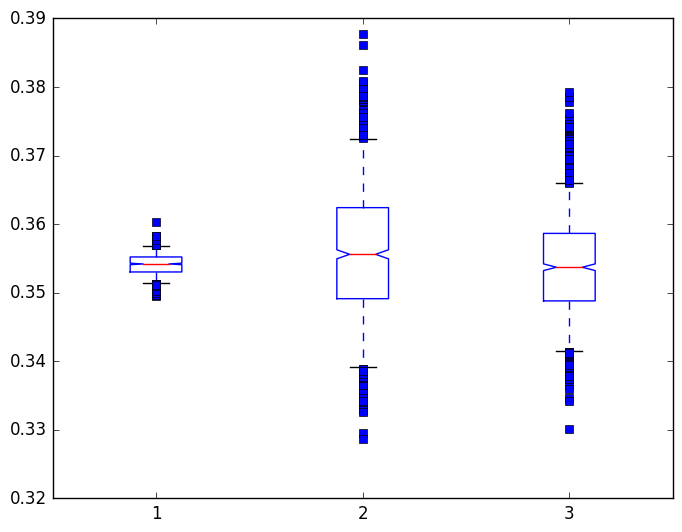

Dict{Any,Any} with 6 entries:
  "medians"  => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "whiskers" => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "fliers"   => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "boxes"    => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "caps"     => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x2…
  "means"    => Any[]

In [88]:
fig = figure("pyplot_boxplot",figsize=(10,10))
boxplot(data_small, # Each column/cell is one box
notch=true, # Notched center
whis=0.75, # Whisker length as a percent of inner quartile range
widths=0.25, # Width of boxes
vert=true, # Horizontal boxes
sym="rs") # Symbol color and shape (rs = red square)

In [98]:
data_small

1000×3 Array{Float64,2}:
 0.356021  0.353919  0.348794
 0.354023  0.365544  0.366823
 0.354424  0.346876  0.358811
 0.353907  0.350196  0.349504
 0.353677  0.362378  0.36008 
 0.352181  0.370435  0.348093
 0.35423   0.348975  0.341589
 0.352368  0.340981  0.3614  
 0.354167  0.355764  0.365325
 0.355401  0.359796  0.357229
 0.351867  0.35174   0.350755
 0.35466   0.348708  0.352511
 0.3528    0.368243  0.361942
 ⋮                           
 0.353694  0.368235  0.356393
 0.356415  0.354202  0.355208
 0.351306  0.347831  0.359809
 0.356554  0.365542  0.346153
 0.354652  0.338599  0.349869
 0.354009  0.346988  0.359323
 0.352896  0.352184  0.352496
 0.354774  0.353368  0.346856
 0.354689  0.357457  0.347398
 0.351171  0.348622  0.346979
 0.35291   0.350583  0.357052
 0.351553  0.36065   0.346937

In [110]:
fig = figure("pyplot_boxplot",figsize=(12,4))
# ax[:set_ylim]([0.25,0.6])
subplot(131)
p1 = boxplot(data_small,yaxis = ("XLABEL")) # Basic
# fig[:set_ylim]([0.25,0.6])
# xlable("Small Perturbation")

subplot(132)
boxplot(data_med)

subplot(133)
boxplot(data_high)# (gD = green diamond)

# subplot(224)
# boxplot(data, # Each column/cell is one box
# 	notch=true, # Notched center
# 	whis=0.75, # Whisker length as a percent of inner quartile range
# 	widths=0.25, # Width of boxes
# 	vert=false, # Horizontal boxes
# 	sym="rs") # Symbol color and shape (rs = red square)

suptitle("Box Plot Examples")
gcf() # Needed for IJulia to plot inline

LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, kw)) <class 'TypeError'>
TypeError("boxplot() got an unexpected keyword argument 'yaxis'",)
[39m

In [102]:
[['a','b','c']]

1-element Array{Array{Char,1},1}:
 ['a', 'b', 'c']

In [96]:
?boxplot

search: boxplot



Make a box and whisker plot.

Call signature::

  boxplot(self, x, notch=None, sym=None, vert=None, whis=None,
          positions=None, widths=None, patch_artist=False,
          bootstrap=None, usermedians=None, conf_intervals=None,
          meanline=False, showmeans=False, showcaps=True,
          showbox=True, showfliers=True, boxprops=None,
          labels=None, flierprops=None, medianprops=None,
          meanprops=None, capprops=None, whiskerprops=None,
          manage_xticks=True, autorange=False):

Make a box and whisker plot for each column of ``x`` or each
vector in sequence ``x``.  The box extends from the lower to
upper quartile values of the data, with a line at the median.
The whiskers extend from the box to show the range of the
data.  Flier points are those past the end of the whiskers.

Parameters
----------
x : Array or a sequence of vectors.
    The input data.

notch : bool, optional (False)
    If `True`, will produce a notched box plot. Otherwise, a
    rectan